In [160]:
a = np.array([0, 0, 1, 0, 0, 1])
b = [1, 2, 3]
b * (a[b] == 1)

array([0, 2, 0])

In [174]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Clue:
    def __init__(self, players):
        # Game elements
        self.suspects = ['Miss Scarlet', 'Colonel Mustard', 'Mrs. White', 'Mr. Green', 'Mrs. Peacock', 'Professor Plum']
        self.weapons = ['Candlestick', 'Dagger', 'Lead Pipe', 'Revolver', 'Rope', 'Spanner']
        self.rooms = ['Kitchen', 'Ballroom', 'Conservatory', 'Billiard Room', 'Library', 'Study', 'Hall', 'Lounge', 'Dining Room']
        self.all_cards = self.suspects + self.weapons + self.rooms
        self.solution = {random.choice(self.suspects), random.choice(self.weapons), random.choice(self.rooms)}

        # Player and game state
        self.n_players = len(players)
        self.players = players
        self.current_player = 0
        self.player_cards = {}
        self.turn = 0
        self.winner = None

    def deal_cards(self):
        remaining_cards = [card for card in self.all_cards if card not in self.solution]
        random.shuffle(remaining_cards)
        self.player_deterministic_knowledge = {
            player.name: np.zeros([self.n_players, len(self.all_cards)]) for player in self.players
        }
        self.player_knowledge = {
            player.name: {other_player.name: [] for other_player in self.players if player != other_player} for player in self.players
        }
        for i, player in enumerate(self.players):
            self.player_cards[player] = remaining_cards[i::self.n_players]
            self._initialize_player_knowledge(player)

    def _initialize_player_knowledge(self, player):
        indices = [self.all_cards.index(card) for card in self.player_cards[player]]
        self.player_deterministic_knowledge[player.name][player.id, :] = -1
        self.player_deterministic_knowledge[player.name][:, indices] = -1
        self.player_deterministic_knowledge[player.name][player.id, indices] = 1

    def update_game_state(self, player, move):
        if len(self.player_cards[player]):
          if move[0] == 'ask':
              self._update_game_state_for_ask(player, move)
          elif move[0] == 'accuse':
              self._update_game_state_for_accuse(player, move)

    def _update_game_state_for_ask(self, player, move):
        stop = False
        for p_index, (p, cards) in enumerate(self.player_cards.items()):
            if stop:
                break
            if p_index > self.current_player:
                stop = self._update_for_individual_player(player, p_index, p, move, cards)

        for p_index, (p, cards) in enumerate(self.player_cards.items()):
            if stop:
                break
            if p_index < self.current_player:
                stop = self._update_for_individual_player(player, p_index, p, move, cards)

        for p in self.players:
            zero_count = np.count_nonzero(self.player_deterministic_knowledge[p.name])
            while True:
                self._update_deterministic_based_on_known_cards(p)
                self._update_deterministic_knowledge_from_set_knowledge(p)
                self._update_deterministic_based_on_known_cards(p)
                new_zero_count = np.count_nonzero(self.player_deterministic_knowledge[p.name])
                if zero_count == new_zero_count:
                    break
                zero_count = new_zero_count

    def _update_for_individual_player(self, player, p_index, p, move, cards):
        available_cards = set(move[1:]) & set(cards)
        if available_cards:
            card = available_cards.pop() if len(available_cards) == 1 else self.players[p_index].reveal_card(available_cards)
            c_index = self.all_cards.index(card)
            self.player_deterministic_knowledge[player.name][:, c_index] = -1
            self.player_deterministic_knowledge[player.name][p_index][c_index] = 1

            for other_player in self.players:
                if other_player.name not in [player.name, p.name]:
                    self.player_knowledge[other_player.name][p.name].append(move[1:])
            return True
        else:
            indices = [self.all_cards.index(card) for card in move[1:]]
            for all in self.players:
                self.player_deterministic_knowledge[all.name][p_index, indices] = -1
            return False

    def _update_game_state_for_accuse(self, player, move):
        if set(move[1]) == self.solution:
            self.solution = None
            self.winner = player
        else:
            self.player_cards[player] = []

    def _update_deterministic_knowledge_from_set_knowledge(self, player):
      """Update deterministic knowledge based on the knowledge about sets of cards other players have."""
      for other_player_name, known_sets in self.player_knowledge[player.name].items():
          other_player_id = [p.id for p in self.players if p.name == other_player_name][0]

          for known_set in known_sets:
              known_indices = [self.all_cards.index(card) for card in known_set]

              # Check if any of the cards in the known set is already determined for the other player
              if np.any(self.player_deterministic_knowledge[player.name][other_player_id, known_indices] == 1):
                  continue

              # If all but one card in the known set are marked as not owned by the other player,
              # then the remaining card must be owned by the other player.
              not_owned_indices = known_indices * (self.player_deterministic_knowledge[player.name][other_player_id, known_indices] == -1)
              not_owned_indices = [index for index in not_owned_indices if index != 0]

              if len(not_owned_indices) == len(known_indices) - 1:
                  owned_index = list(set(known_indices) - set(not_owned_indices))[0]
                  self.player_deterministic_knowledge[player.name][other_player_id, owned_index] = 1
                  self.player_deterministic_knowledge[player.name][:, owned_index] = -1
                  self.player_deterministic_knowledge[player.name][other_player_id, owned_index] = 1

    def _update_deterministic_based_on_known_cards(self, player):
        pdk = self.player_deterministic_knowledge[player.name]
        updated_pdk = self.pure_update_pdk(pdk)
        self.player_deterministic_knowledge[player.name] = updated_pdk

    def pure_update_pdk(self, pdk):
        pdk = self._update_for_known_cards(pdk)
        pdk = self._update_for_unknown_cards(pdk)
        return pdk

    def _update_for_known_cards(self, pdk):
        for i, p in enumerate(pdk):
            if np.count_nonzero(p == 0) > 0:
                if np.count_nonzero(p == 1) == 3:
                    pdk[i, p == 0] = -1
                elif (np.count_nonzero(p == 1) + np.count_nonzero(p == 0)) == 3:
                    indices = p == 0
                    pdk[:, indices] = -1
                    pdk[i, indices] = 1
        return pdk

    def _update_for_unknown_cards(self, pdk):
        known_sus = sum(np.max(pdk.T[:6], axis=1))
        known_wep = sum(np.max(pdk.T[6:12], axis=1))
        known_rom = sum(np.max(pdk.T[12:], axis=1))

        pdk.T[:6][np.max(pdk.T[:6], axis=1) == 0] = -1 if known_sus == 5 else pdk.T[:6][np.max(pdk.T[:6], axis=1) == 0]
        pdk.T[6:12][np.max(pdk.T[6:12], axis=1) == 0] = -1 if known_wep == 5 else pdk.T[6:12][np.max(pdk.T[6:12], axis=1) == 0]
        pdk.T[12:][np.max(pdk.T[12:], axis=1) == 0] = -1 if known_rom == 8 else pdk.T[12:][np.max(pdk.T[12:], axis=1) == 0]

        return pdk



    def heatmap1(self):
      fig, axs = plt.subplots(len(self.player_deterministic_knowledge), 1, figsize=(15, len(self.player_deterministic_knowledge) * 3))

      # Define a colormap: 1 for known (green), -1 for not-owned (red), 0 for unknown (gray)
      cmap = plt.cm.colors.ListedColormap(['red', 'gray', 'green'])
      bounds = [-1.5, -0.5, 0.5, 1.5]
      norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

      for i, (p, dk) in enumerate(self.player_deterministic_knowledge.items()):
          cax = axs[i].imshow(dk, cmap=cmap, norm=norm, aspect='auto')
          axs[i].set_title(p, fontsize=14)
          axs[i].set_yticks(ticks=range(self.n_players))
          axs[i].set_yticklabels([p.name for p in self.players], fontsize=10)
          axs[i].set_xticks(ticks=range(len(self.all_cards)))
          axs[i].grid(False)

      axs[-1].set_xticks(ticks=range(len(self.all_cards)))
      axs[-1].set_xticklabels(self.all_cards, rotation=90, fontsize=10)

      # Add colorbar legend
      cbar = fig.colorbar(cax, ax=axs, orientation='horizontal', boundaries=bounds, ticks=[-1, 0, 1], aspect=50)
      cbar.ax.set_xticklabels(['Not Owned', 'Unknown', 'Owned'], fontsize=12)

      plt.tight_layout()
      plt.show()

    def heatmap2(self):
      fig, axs = plt.subplots(len(self.player_deterministic_knowledge), 1, figsize=(4, len(self.player_deterministic_knowledge) * 2.2))

      for i, (p, dk) in enumerate(self.player_deterministic_knowledge.items()):
          axs[i].imshow(dk, cmap='hot', aspect='auto')
          axs[i].set_title(p)
          axs[i].set_yticks(ticks=range(self.n_players))
          axs[i].set_yticklabels([p.name for p in self.players])
          axs[i].set_xticks(ticks=range(len(self.all_cards)))
          axs[i].set_xticklabels(self.all_cards, rotation=90, fontsize=8)

      plt.tight_layout()
      plt.show()

    def heatmap(self):
      fig, axs = plt.subplots(len(self.player_deterministic_knowledge), 1, figsize=(4, len(self.player_deterministic_knowledge)*1.8))
      for i, (p, dk) in enumerate(self.player_deterministic_knowledge.items()):
        axs[i].imshow(dk, cmap='hot')#,extent=[-0.5, 9.5, 9.5, -0.5])
        axs[i].set_title(p)
        axs[i].set_yticks(ticks=range(game.n_players))
        axs[i].set_yticklabels([p.name for p in game.players])
        axs[i].set_xticks(ticks=range(len(game.all_cards)))
        axs[i].grid(True, which='both', color='gray', linewidth=0.5, axis='both', zorder=0)


      plt.xticks(ticks=range(len(game.all_cards)),labels=game.all_cards, rotation=90)
      plt.show()

    def game_over(self):
        return self.solution is None or self.turn > 200

class Player:
    def __init__(self, name):
        self.name = name
        self.id = -1

    def reveal_card(self, cards):
        """Reveal one of the available cards."""
        return random.choice(list(cards))

    def make_move(self, game):
        """To be overridden by subclasses to make a move."""
        pass


class HumanPlayer(Player):
    def make_move(self, game):
        """Get input from the human player for their move."""
        move_type = input(f'{self.name}, your move (ask/accuse): ').strip()
        if move_type == 'ask':
            suspect = input('Ask about suspect: ')
            weapon = input('Ask about weapon: ')
            room = input('Ask about room: ')
            return ['ask', suspect, weapon, room]
        elif move_type == 'accuse':
            suspect = input('Accuse suspect: ')
            weapon = input('Accuse weapon: ')
            room = input('Accuse room: ')
            return ['accuse', {suspect, weapon, room}]


class RandomBot(Player):
    def make_move(self, game):
        """Make a random move."""
        if sum(game.player_deterministic_knowledge[self.name].sum(axis=0) == -game.n_players) == 3:
            card_indices = np.where(game.player_deterministic_knowledge[self.name].sum(axis=0) == -game.n_players)[0]
            return ['accuse', {game.all_cards[card_index] for card_index in card_indices}]
        return ['ask', random.choice(game.suspects), random.choice(game.weapons), random.choice(game.rooms)]

In [175]:
class SmartBot(Player):
    def make_move(self, game):
        knowledge = game.player_deterministic_knowledge[self.name]

        # Prioritize asking about the most uncertain cards
        uncertain_cards = np.where(knowledge.max(axis=0) == 0)[0]

        # If there's information about all cards, then make an accusation
        if len(uncertain_cards) == 0:
            card_indices = np.where(knowledge.sum(axis=0) == -game.n_players)[0]
            return ['accuse', {game.all_cards[card_index] for card_index in card_indices}]

        uncertain_suspects = [game.all_cards[i] for i in uncertain_cards if game.all_cards[i] in game.suspects]
        uncertain_weapons = [game.all_cards[i] for i in uncertain_cards if game.all_cards[i] in game.weapons]
        uncertain_rooms = [game.all_cards[i] for i in uncertain_cards if game.all_cards[i] in game.rooms]

        # If a category is empty, randomly choose from the known unconfirmed cards in that category
        if not uncertain_suspects:
            unconfirmed_suspects = np.where((knowledge.sum(axis=0) > -game.n_players) & np.isin(game.all_cards, game.suspects))[0]
            uncertain_suspects = [game.all_cards[i] for i in unconfirmed_suspects]
        if not uncertain_weapons:
            unconfirmed_weapons = np.where((knowledge.sum(axis=0) > -game.n_players) & np.isin(game.all_cards, game.weapons))[0]
            uncertain_weapons = [game.all_cards[i] for i in unconfirmed_weapons]
        if not uncertain_rooms:
            unconfirmed_rooms = np.where((knowledge.sum(axis=0) > -game.n_players) & np.isin(game.all_cards, game.rooms))[0]
            uncertain_rooms = [game.all_cards[i] for i in unconfirmed_rooms]

        return ['ask', random.choice(uncertain_suspects), random.choice(uncertain_weapons), random.choice(uncertain_rooms)]

In [176]:
def play_game(n_players=6, bot_type=RandomBot):
    players = []
    for i in range(n_players):
        player = bot_type(f"Bot_{i}")
        player.id = i
        players.append(player)
    game = Clue(players=players)

    game.deal_cards()

    while not game.game_over():
        current_player = game.players[game.current_player]
        move = current_player.make_move(game)
        game.update_game_state(current_player, move)
        game.current_player = (game.current_player + 1) % game.n_players
        game.turn += 1
        # game.heatmap()
    if game.solution is None:
        print(f"The winner is {game.winner.name}! at Turn {game.turn}")
    else:
        print("No one could solve the mystery!")
    game.heatmap2()

The winner is Bot_0! at Turn 37


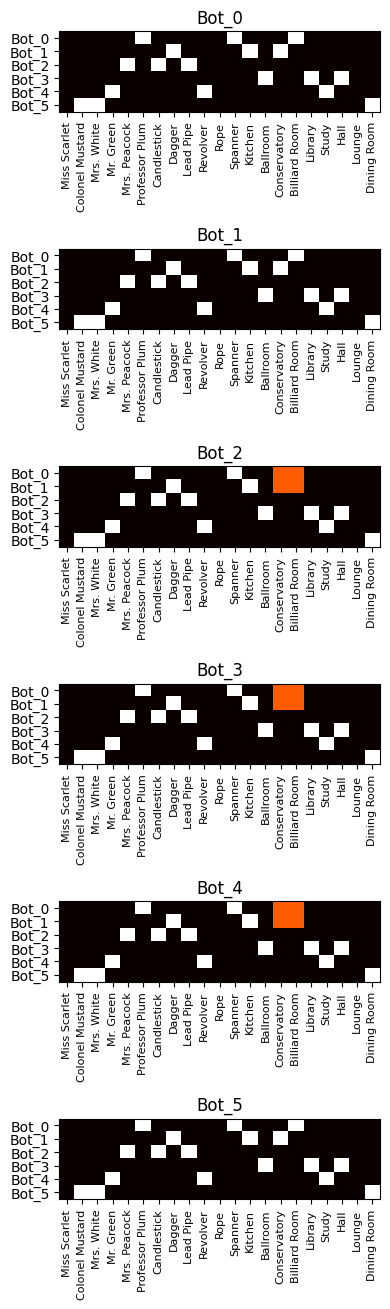

In [178]:
winner = play_game(n_players=6, bot_type=SmartBot)

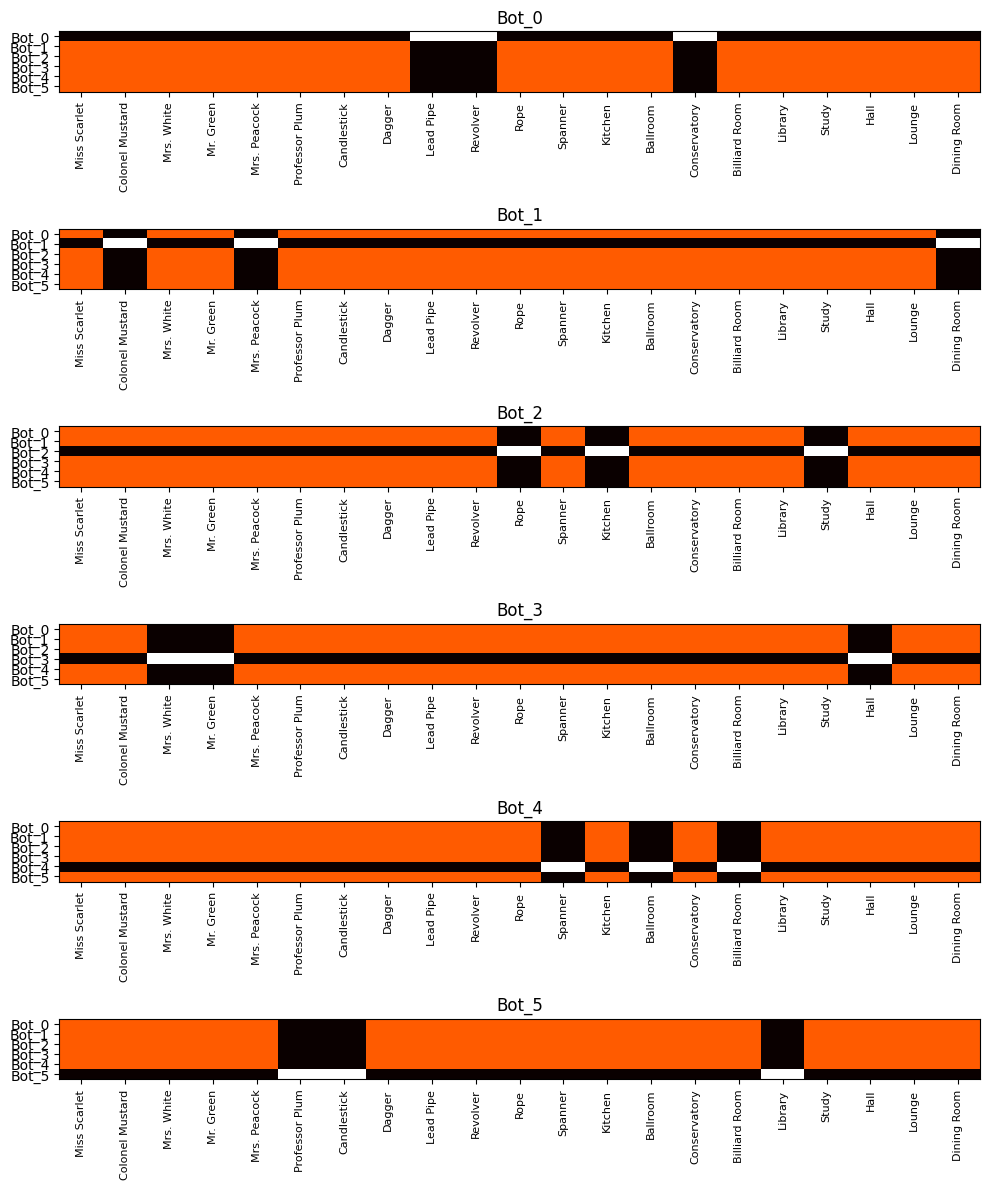

In [99]:
n_players = 6
players = []
for i in range(n_players):  # -1 to make space for our new SmartBot
  player = SmartBot(f"Bot_{i}")
  player.id = i
  players.append(player)
game = Clue(players=players)
game.deal_cards()
game.heatmap()

Bot_0 ['ask', 'Mr. Green', 'Spanner', 'Hall']


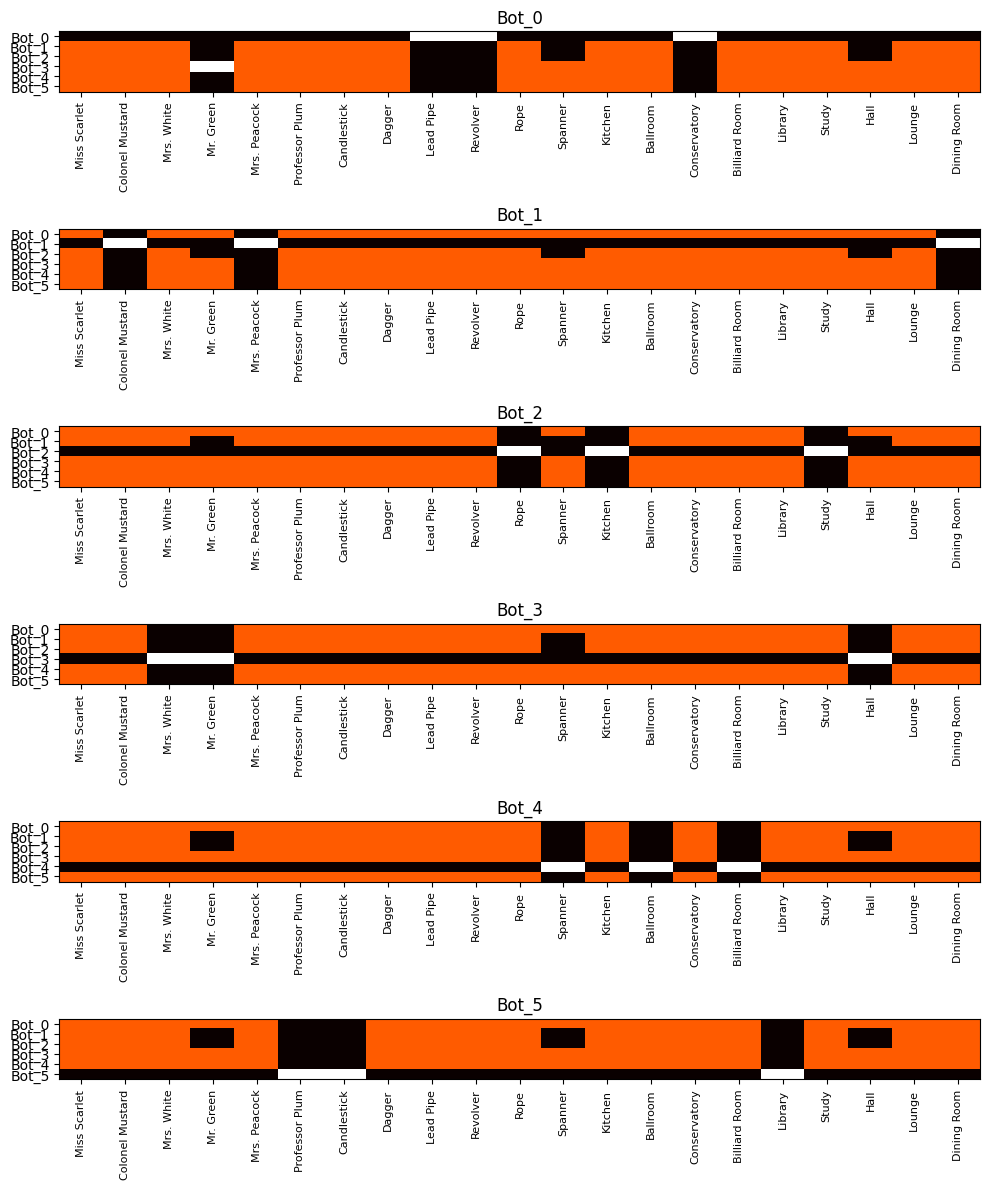

In [100]:
current_player = game.players[game.current_player]
move = current_player.make_move(game)
print(current_player.name, move)
game.update_game_state(current_player, move)
game.current_player = (game.current_player + 1) % game.n_players
game.turn += 1
game.heatmap()